In [71]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()


We are using the training set 2 because we need to understand how to tune the threshold on the reconstruction error that we obtain using PCA.

In [72]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

discrete_variables = [f'S_PU{num+1}' for num in range(11)] + ['S_V2']    
data_trn_2 = data_trn_2.drop(columns=discrete_variables)

labels = data_trn_2['ATT_FLAG']

data_trn_2.drop(columns=['ATT_FLAG'], inplace=True)

print(data_trn_2.shape)

(4177, 31)


In [73]:
remapping_positives = 50
labels = labels.map({-999: 0, 1: remapping_positives})

First of all... NORMALIZATION!

In [74]:
normalized_df=(data_trn_2-data_trn_2.mean())/data_trn_2.std()
# normalized_df.head()

# remove columns with NaN (they had only the same value --> not possible to normalize them)
normalized_df.dropna(axis='columns', inplace=True)
# normalized_df.head()

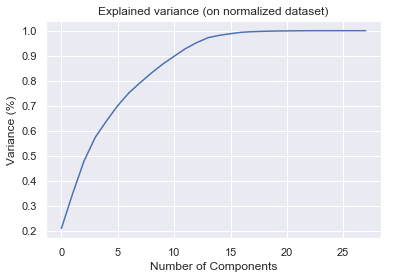

In [75]:
n_of_components = normalized_df.shape[1]
pca_fit = PCA(n_of_components).fit(normalized_df)

plt.figure()
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained variance (on normalized dataset)')
plt.show()

Let's create a function that retrieves the number of principal components that we need if we want to capture a certain percentage of variance in the data

In [76]:
def get_num_of_principal_components(fitted_pca, desired_variance_perc):
    cumulative_variance = np.cumsum(fitted_pca.explained_variance_ratio_)
    return [i for i in range(len(cumulative_variance)) if cumulative_variance[i] > desired_variance_perc/100][0]

Let's use this number of components to project the data into a lower dimensional feature space. In order to capture the normal behaviour (and therefore being able to detect anomalies) we need to capture enough variance of the data, but not too much. Otherwise we would also learn about the anomalies. This is actually the power of PCA!

In [77]:
var_perc_to_capture = 80  # we want to capture 80% of the variance, to capture the normal behavior

n = get_num_of_principal_components(pca_fit, var_perc_to_capture)
print(f"{n} components will be used to project into the normal space")

pca = PCA(n_components=n)
df_pca = pd.DataFrame(pca.fit_transform(normalized_df), normalized_df.index)
df_pca.head()

8 components will be used to project into the normal space


,0,1,2,3,4,5,6,7
2016-07-04 00:00:00,-0.082076,-0.837768,1.910539,2.145791,1.294063,-1.166258,-1.458788,0.226568
2016-07-04 01:00:00,0.661386,2.600156,2.744080,1.470051,-1.703855,1.445069,-1.978774,0.401720
2016-07-04 02:00:00,0.925890,2.914836,2.525965,1.639343,-2.824240,1.842735,-0.503091,-0.494060
2016-07-04 03:00:00,-1.312981,3.521166,1.776369,0.520519,1.390012,2.456869,2.991623,-1.123716
2016-07-04 04:00:00,-0.972529,4.012716,1.987852,-0.219327,2.350951,2.223345,1.155874,-0.239861


Let's now reconstruct the original data from the lower-dimensional projection that we obtain with PCA

In [78]:
df_reconstructed = pd.DataFrame(pca.inverse_transform(df_pca), normalized_df.index)
df_reconstructed.columns = normalized_df.columns

# print(normalized_df.shape)
# print(df_reconstructed.shape)

# Now, we compute the residuals: original normalized data - reconstructed data

residual_df = normalized_df.subtract(df_reconstructed)

We want to see what the residual obtained with PCA reconstruction is. We use sensors for which we know there has been attacks in this training set.

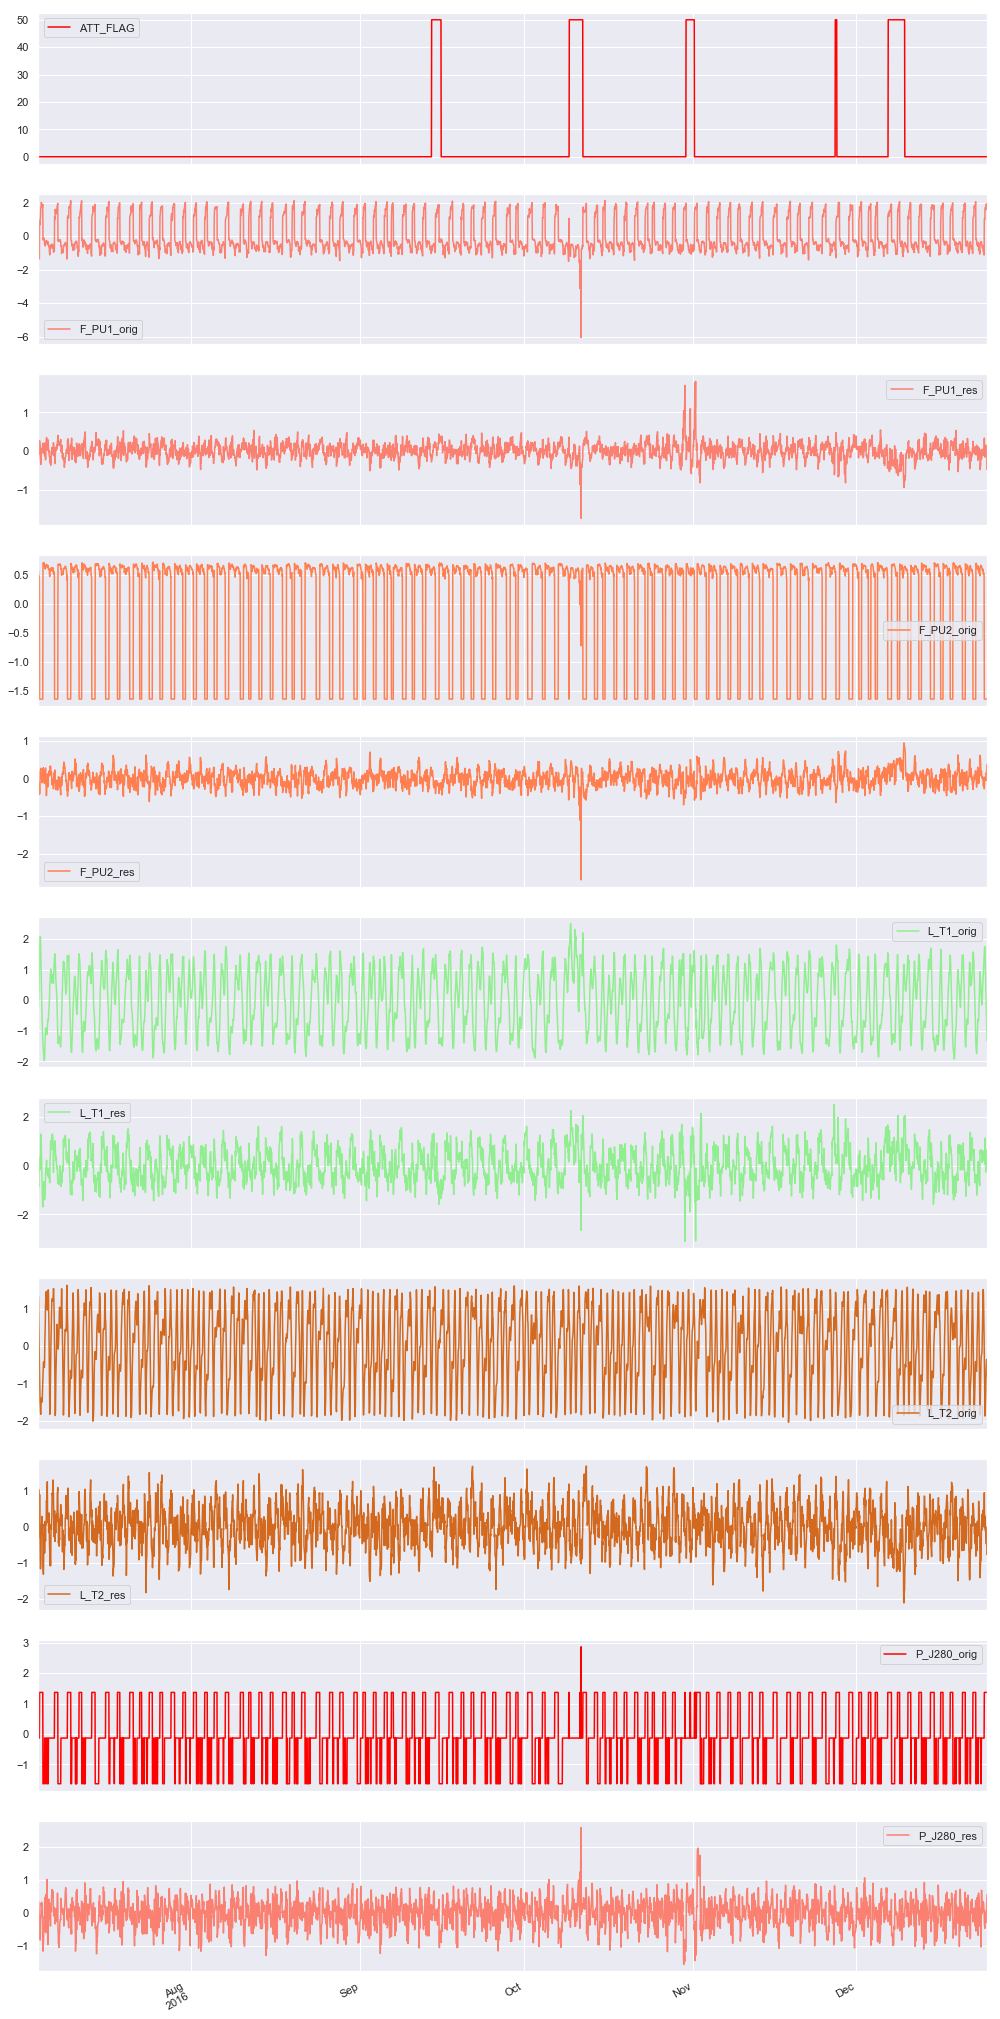

In [79]:
cols_plot = ['L_T1', 'F_PU1', 'F_PU2', 'P_J280', 'L_T2']
original = normalized_df[cols_plot]
original.columns = [col + "_orig" for col in cols_plot]

residuals = residual_df[cols_plot]
residuals.columns = [col + "_res" for col in cols_plot]


to_plot_df = pd.concat([original, residuals, labels], axis=1)
to_plot_df.index = normalized_df.index

to_plot_df = to_plot_df[sorted(to_plot_df.columns)] # this is done just to reorder them and having an ordered plot

# to_plot_df.loc['2016-10-01':'2016-11-10'].plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
to_plot_df.plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
plt.show()

It seems like PCA is actually able to detect some of the anomalies (other attacks are related to other sensors which are not displayed here!)

Let's now square the residuals (we are not interested in the sign) and sum across all the sensors --> we have an overall idea of the PCA residuals over the whole system

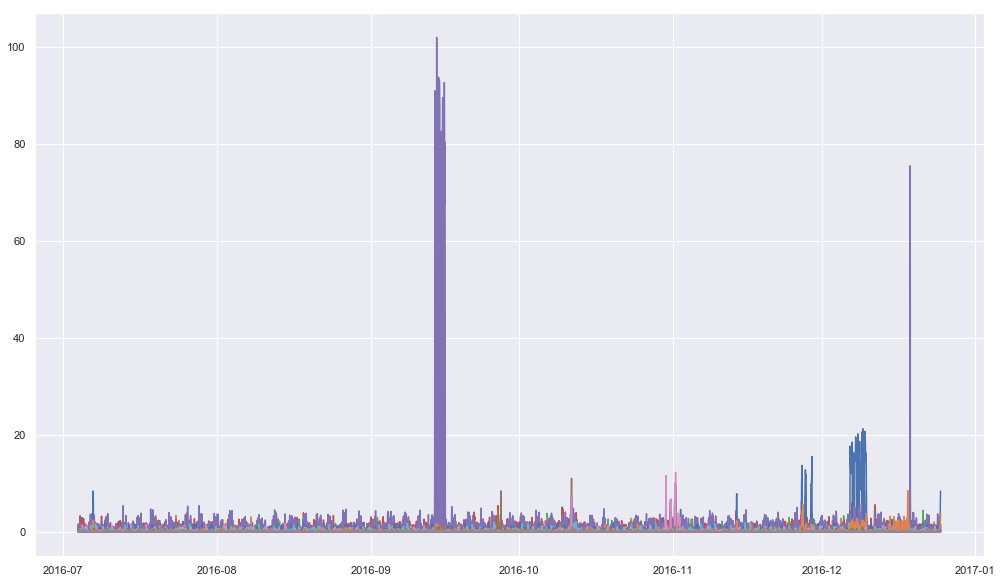

In [80]:
squared_res_df = pd.DataFrame(np.power(residual_df, 2), residual_df.index)

# Let's just have a look at the different residuals altogether (and also labels, why not)
to_plot_df = pd.concat([squared_res_df], axis=1)
plt.figure(figsize=(17,10))
plt.plot(to_plot_df)
plt.show()

Now, let's sum all these squared residuals

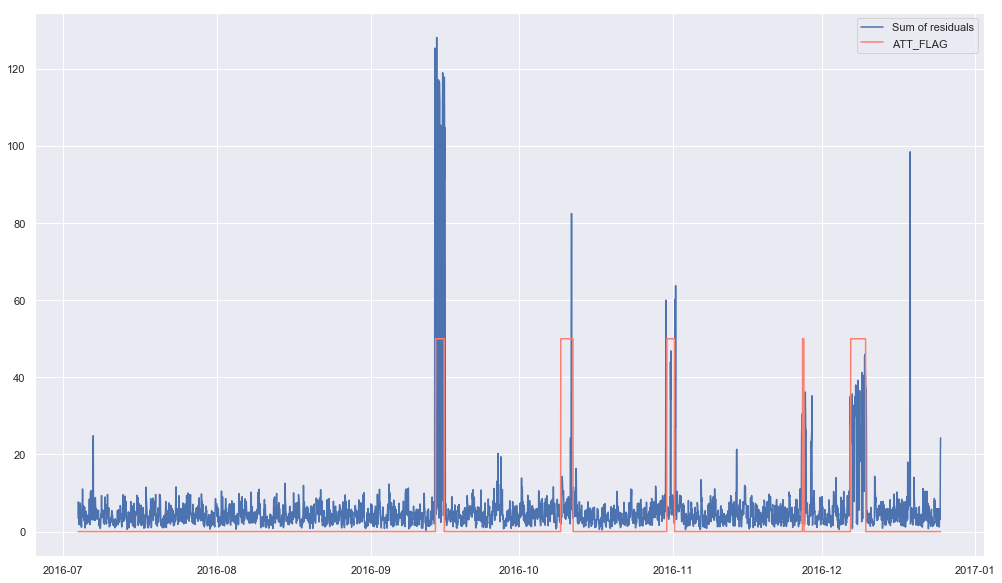

In [81]:
squared_sum_res = squared_res_df.sum(axis=1)
plt.figure(figsize=(17,10))
plt.plot(squared_sum_res, label='Sum of residuals')
plt.plot(labels, color='salmon')
plt.legend()
plt.show()

Some of the attacks can be clearly found using the residuals. Also, it seems there are some attacks which are not labeled (on https://batadal.net/data.html they say "This dataset with partially labeled data was released on November 28 2016. The dataset is around 6 months long and contains several attacks, some of which are approximately labeled")

### Threshold setup

Let's have a look at the eigenvalues we have

In [82]:
print(f"{n} components used to capture normal behaviour: ")
normal_eigvals = pca_fit.explained_variance_[:n]
print(normal_eigvals)

print(f"\n\n{normalized_df.shape[1] - n} components used to capture anomalies:")
abnormal_eigvals = pca_fit.explained_variance_[n:]
print(abnormal_eigvals)

8 components used to capture normal behaviour: 
[5.87531288 3.90055973 3.61600714 2.67032615 1.84395347 1.71493388
 1.43792837 1.1387088 ]


20 components used to capture anomalies:
[1.08373361e+00 9.91125425e-01 8.67681967e-01 8.47994587e-01
 6.75774451e-01 5.51129565e-01 2.64700501e-01 1.83292834e-01
 1.61684080e-01 7.06658332e-02 3.78171886e-02 2.93164407e-02
 1.44895357e-02 1.16579382e-02 9.30031485e-03 1.73607770e-03
 1.06445438e-04 5.95523519e-05 2.22079185e-06 1.01164375e-06]


We need to compute a threshold for the residual error, as explained in the paper about PCA. (Diagnosing Network-wide traffic anomalies)

Threshold: 26.153470116034278


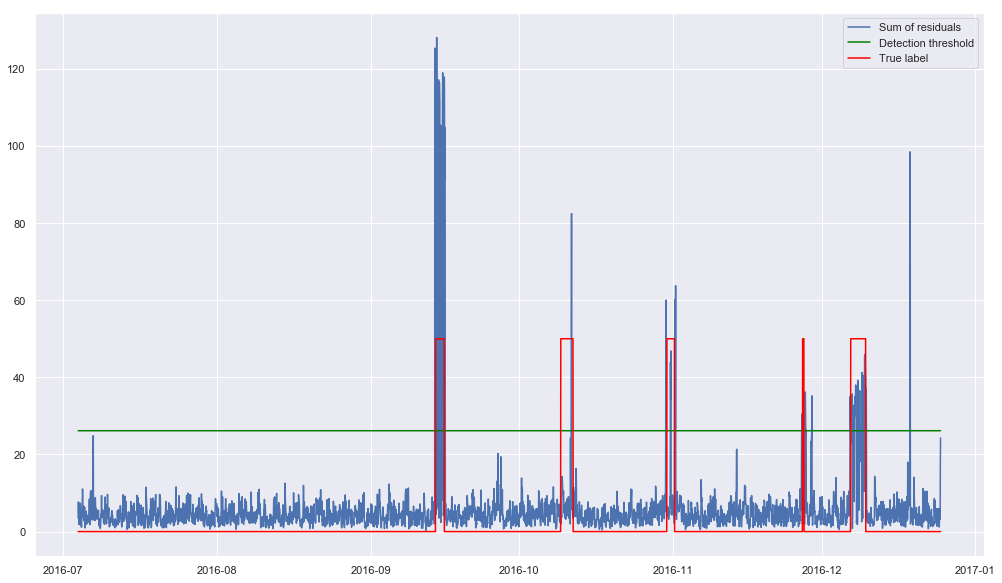

In [83]:
r = n # number of normal components for us

phi_1 = np.sum(abnormal_eigvals)
phi_2 = np.sum(np.power(abnormal_eigvals, 2))
phi_3 = np.sum(np.power(abnormal_eigvals, 3))

h_0 = (2 * phi_1 * phi_3) / (3 * phi_2**2)
h_0 = 1 - h_0

# c_alpha is a hyperparameter, also in the paper.
c_alpha = 3.7 # tried several attempts. This value leads to a 'few false positives', as requested in the assignment paper.

# multiple steps to make it understandable
delta_alpha_squared = 0
delta_alpha_squared += c_alpha * np.sqrt(2 * phi_2 * h_0**2) / phi_1
delta_alpha_squared += 1
delta_alpha_squared += phi_2 * h_0 * (h_0 - 1) / (phi_1**2)
delta_alpha_squared **= (1/h_0)
delta_alpha_squared *= phi_1

print(f"Threshold: {delta_alpha_squared}")

detection = squared_sum_res > delta_alpha_squared
detection = detection.astype(int)
detection = detection.map({0:0, 1:(remapping_positives)}) # remapping_positives is defined at the beginning of the code

threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(detection.shape[0])]), detection.index)


plt.figure(figsize=(17,10))
plt.plot(squared_sum_res, label='Sum of residuals')
plt.plot(threshold, label='Detection threshold', color='green')
plt.plot(labels, color='red', label='True label')
plt.legend()
plt.show()

Let's compute some metrics to see how good this detection on the training data is

In [84]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (remapping_positives if true_attack else 0)) 
        & 
        (results['pred'] == (remapping_positives if pred_attack else 0))
    ]
#     display(result.head())
    return result.shape[0]

res = pd.concat([labels, detection], axis=1)
res.columns = ['true', 'pred']

t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

precision = t_p/(t_p + f_p)
recall = t_p/(t_p + f_n)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"{f_p} false positives out of {t_p + f_p} attacks detected. ({t_p + f_n} attacks were labeled) --> {t_p} attacks correctly detected!")

Precision: 0.7281553398058253
Recall: 0.3424657534246575
28 false positives out of 103 attacks detected. (219 attacks were labeled) --> 75 attacks correctly detected!


It is said that the dataset is partially labeled, so maybe our false positives are not that false, afterall.

## Investigation on the type of anomalies that we can detect with PCA

We will now investigate the True Positives, to understand what we are able to detect with using PCA

In [85]:
detected = res[(res['true'] == remapping_positives) & (res['pred'] == remapping_positives)]
print(detected.index[0])
print(detected.index[-1])

2016-09-14 03:00:00
2016-12-09 21:00:00


All detected anomalies are from September 2016 to the end of the data (end of 2016). Therefore, we focus only on this slice of data

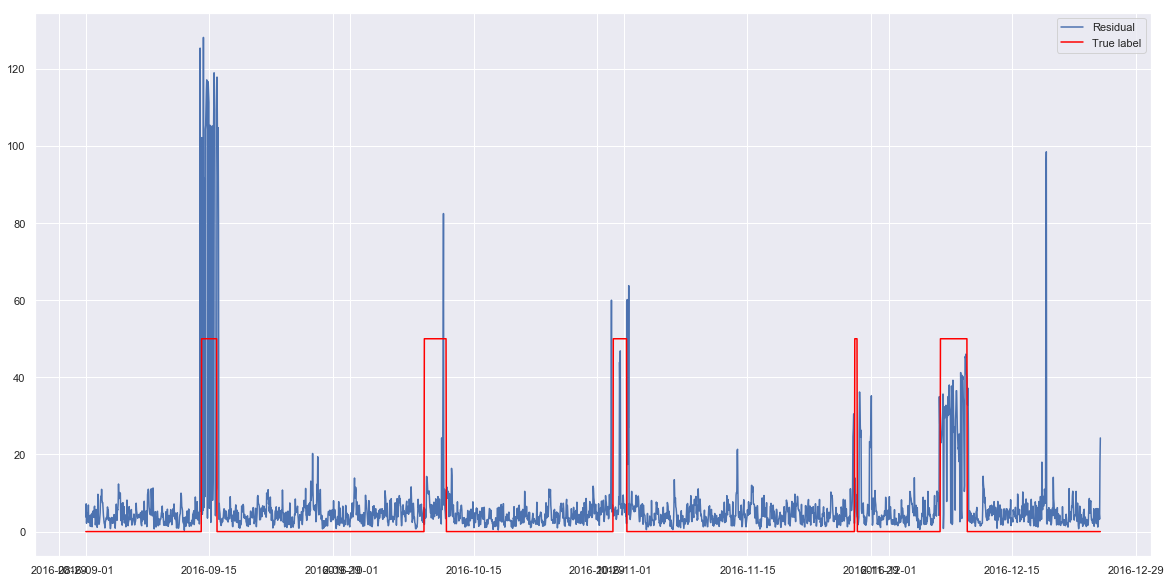

In [86]:
start = '2016-09'
end = '2016-12-29'

plt.figure(figsize=(20,10))
plt.plot(squared_sum_res.loc[start:end], label='Residual')
plt.plot(labels.loc[start:end], color='red', label='True label')
plt.legend()
plt.show()

Let's look at the first one. By looking at the labels for this dataset, the attack interested tower 7. Therefore, we show here signals relevant for this attack.

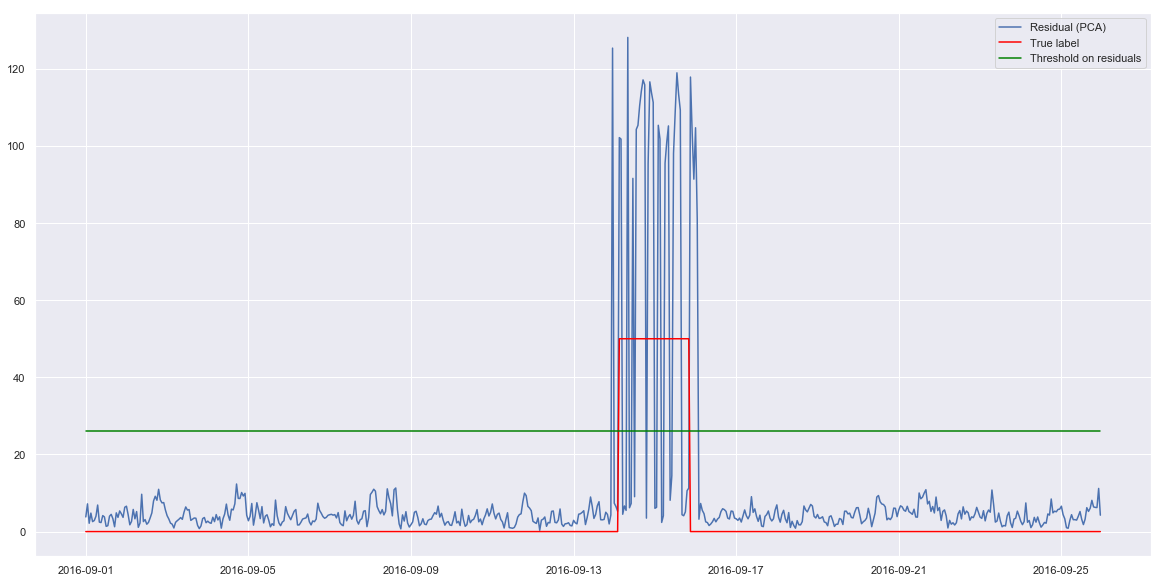

In [96]:
start = '2016-09-01'
end = '2016-09-25'
cols_plot = ['L_T7', 'F_PU10', 'F_PU11']



plt.figure(figsize=(20,10))
plt.plot(squared_sum_res.loc[start:end], label='Residual (PCA)')
plt.plot(labels.loc[start:end], color='red', label='True label')
plt.plot(threshold.loc[start:end], color='green', label='Threshold on residuals')
plt.legend()
plt.show()

Let's see what kind of shape this anomaly has, by looking at the original signals

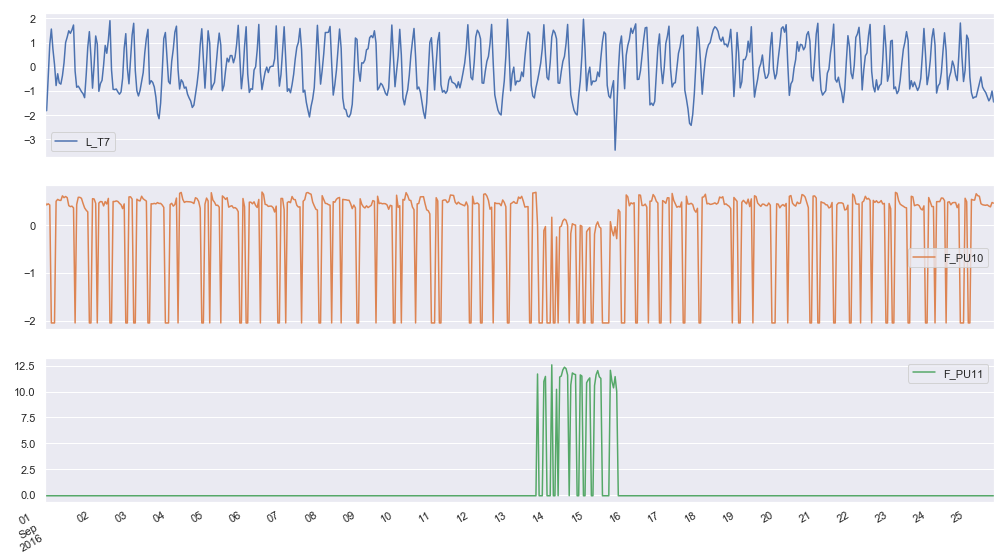

In [101]:
normalized_df[cols_plot].loc[start:end].plot(subplots=True, figsize=(17,10))
plt.show()

# questions to clarify

1) explanations for the number of used principal components --> is that enough to show the amount of captured variance and empirically decide how much variance to capture?

2) The detection threshold is determined soundly --> there is a hyperparameter in the paper about PCA. It is not clear to me how to actually define it. Also, the assignment says "to find a few false positives". This can be interpreted, what should we do?

3) The anomaly types are identified. --> what does this mean? visual inspection?